# Projeto de Machine Learning: Classificação - Vitítimas do Titanic
#### Esse projeto tem como objetivo classificar se alguém sobreviveu ou não ao desastre do Titanic, através de modelos de classificação, a base de dados utilizada pode ser encontrada no site Kaggle: https://www.kaggle.com/competitions/titanic


## Parte 1 - Preparação:

### Importando bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

### Carregando dados:

In [2]:
train_df = pd.read_csv(r'C:\Users\Thomas\Notebooks\Planilhas\train.csv')
test_df = pd.read_csv(r'C:\Users\Thomas\Notebooks\Planilhas\test.csv')

In [3]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Parte 2 - Exploração dos dados:

### Conhecendo os dados:

In [4]:
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

##### Um detalhe curioso é que no último quartil da coluna "Fare" há uma variação muito grande nos dados.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Identificando os problemas do dataset:

In [7]:
train_df.isna().sum()/len(train_df) # % de dados faltando por coluna

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

##### Observa-se que a maioria dos dados da coluna "Cabin" estão vazios, e vazios em pequenas porcentagens em "Age" and "Embarked".

### Identificando correlações:

<AxesSubplot:xlabel='Survived', ylabel='Sex'>

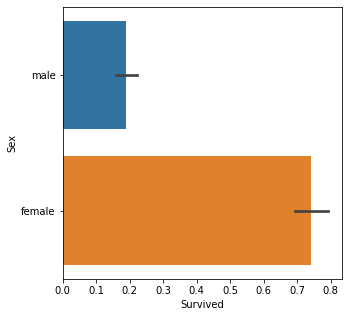

In [8]:
plt.figure(figsize=(5,5))
sns.barplot(data=train_df, y = 'Sex', x = 'Survived')

##### É evidente que ser mulher é um fator importante para explicar a sobrevivência.

<AxesSubplot:xlabel='Survived', ylabel='Embarked'>

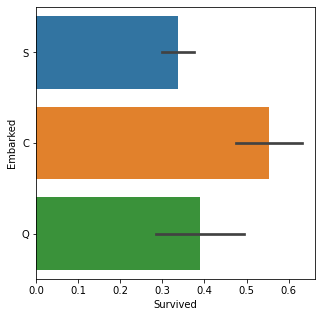

In [9]:
plt.figure(figsize=(5,5))
sns.barplot(data=train_df, y = 'Embarked', x = 'Survived')

##### Os dados mostram que pessoas embarcadas em Cherbourg tem maior probabilidade de sobreviver.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

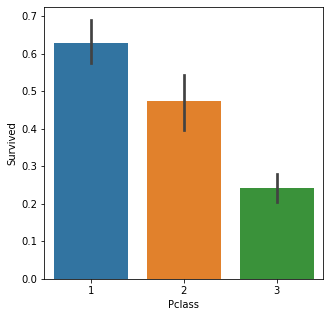

In [10]:
plt.figure(figsize=(5,5))
sns.barplot(data=train_df, x = 'Pclass', y = 'Survived')

##### É possível identificar uma ordinalidade nessa feature, quanto menor o número da "Pclass" maior a probabilidade de sobreviver.

## Parte 3 - Transformação dos dados:

### Retirando colunas que não serão incluídas no modelo:

In [11]:
train_df.drop(['Name','Ticket','Cabin','PassengerId'],axis=1, inplace=True)

##### As colunas "Name", "Ticket" ,"Cabin" e "PassengerId" foram excluidas pois não serão de muita serventia ao modelo. 

### Dividindo as colunas:

#### Separando a feature alvo:

In [12]:
y  = train_df['Survived']
train_df.drop('Survived',axis=1,inplace=True)

#### Separando as colunas númericas e categóricas:

In [13]:
numeric_columns = train_df.select_dtypes(include=np.number).columns.to_list()
numeric_columns

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [14]:
categorical_columns = train_df.select_dtypes(include=object).columns.to_list()
categorical_columns

['Sex', 'Embarked']

### Transformando as features categóricas ordinais:

In [15]:
def ordinal_encoder_pclass(row): # Função para ordenar os valores de "Pclass"
    if row == 3:
        return 0
    elif row == 2:
        return 1
    elif row == 1:
        return 2
    else:
        return np.nan

In [16]:
train_df['Pclass'] = train_df['Pclass'].apply(ordinal_encoder_pclass)

In [17]:
train_df['Pclass']

0      0
1      2
2      0
3      2
4      0
      ..
886    1
887    2
888    0
889    2
890    0
Name: Pclass, Length: 891, dtype: int64

##### "Pclass" é a única feature categórica ordinal que precisa ser preparada antes do modelo, "SibSp" e "Parch" já estão prontas para ser usadas no modelo.

### Trabalhando as features númericas:

In [18]:
train_df.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       0    male  22.0      1      0   7.2500        S
1       2  female  38.0      1      0  71.2833        C
2       0  female  26.0      0      0   7.9250        S
3       2  female  35.0      1      0  53.1000        S
4       0    male  35.0      0      0   8.0500        S

In [19]:
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler()

In [20]:
train_df[numeric_columns] = imputer.fit_transform(train_df[numeric_columns]) # Completando os dados faltando com a mediana.

In [21]:
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns]) # Escalando os valores.

In [22]:
train_df.head()

Pclass     Sex       Age  SibSp  Parch      Fare Embarked
0     0.0    male  0.271174  0.125    0.0  0.014151        S
1     1.0  female  0.472229  0.125    0.0  0.139136        C
2     0.0  female  0.321438  0.000    0.0  0.015469        S
3     1.0  female  0.434531  0.125    0.0  0.103644        S
4     0.0    male  0.434531  0.000    0.0  0.015713        S

##### As variáveis númericas foram trabalhadas para otimizar o funcionamento do modelo, completadas as colunas faltantes e os números foram escalados.

### Trabalhando as features categóricas:

#### Retirando os valores nulos das colunas categóricas:

In [23]:
train_df.loc[train_df['Embarked'].isna() == True]

Pclass     Sex       Age  SibSp  Parch     Fare Embarked
61      1.0  female  0.472229    0.0    0.0  0.15615      NaN
829     1.0  female  0.773813    0.0    0.0  0.15615      NaN

In [24]:
train_df.Embarked.value_counts() # Contagem dos valores

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
train_df.loc[[61,829],'Embarked'] = 'S' 

In [26]:
train_df.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

###### Os valores de "Embarked" faltando foram substituídos pelo valor mais constante da coluna.

#### Encoding das variavéis:

In [27]:
encoder = OneHotEncoder(sparse = False) 

In [28]:
encoder.fit(train_df[categorical_columns])

categorical_names = encoder.get_feature_names_out()

train_df[categorical_names] = encoder.transform(train_df[categorical_columns])

In [29]:
train_df.drop(['Sex','Embarked'],axis=1,inplace=True) #Excluindo as colunas que foram transformadas.

In [30]:
train_df.head()

Pclass       Age  SibSp  Parch      Fare  Sex_female  Sex_male  Embarked_C  \
0     0.0  0.271174  0.125    0.0  0.014151         0.0       1.0         0.0   
1     1.0  0.472229  0.125    0.0  0.139136         1.0       0.0         1.0   
2     0.0  0.321438  0.000    0.0  0.015469         1.0       0.0         0.0   
3     1.0  0.434531  0.125    0.0  0.103644         1.0       0.0         0.0   
4     0.0  0.434531  0.000    0.0  0.015713         0.0       1.0         0.0   

   Embarked_Q  Embarked_S  
0         0.0         1.0  
1         0.0         0.0  
2         0.0         1.0  
3         0.0         1.0  
4         0.0         1.0

###### Todas os valores categóricos foram trabalhados para serem lidos corretamente pelos modelos.

### Separando o dataset:

In [31]:
X_train, X_validation, y_train, y_validation = train_test_split(train_df, y, random_state=20)

## Parte 4 - Seleção dos modelos:

### Logistic Regression:

#### Montando modelo:

In [32]:
model_lr = LogisticRegression(random_state=20, n_jobs = -1) # Modelo base
parametros_lr = {'C':[0.1,0.5,0.8,1], 
                 'solver':('newton-cg','lbfgs','liblinear','sag','saga')} # Parametros que serão testados

model_lr_otimizado = GridSearchCV(model_lr, param_grid = parametros_lr,
                                  scoring = {'F1_score':make_scorer(f1_score)},
                                  refit = 'F1_score',
                                  n_jobs = -1)

In [33]:
model_lr_otimizado.fit(X_train,y_train) #Testando hiperparâmetros

model_lr_otimizado.best_params_ # Melhores hiperparâmetros

{'C': 0.8, 'solver': 'newton-cg'}

#### Testando o modelo:

In [35]:
model_lr_predict = model_lr_otimizado.predict(X_validation) # Testando o modelo

score_lr = f1_score(y_validation,model_lr_predict)

print('O modelo de regressão logistíca possui f1_score de {}'.format(score_lr))

O modelo de regressão logistíca possui f1_score de 0.7329192546583853


In [36]:
labels = model_lr_otimizado.classes_ 

confusion_matrix_lr = confusion_matrix(y_validation, model_lr_predict, labels = labels)

pd.DataFrame(confusion_matrix_lr)

0   1
0  121  21
1   22  59

#### O modelo de regressão logística após ser otimizado teve um resultado de 73,2% de precisão no f1_score, que equilibra as métricas de recall e precision, errando 43 previsões de 223, havendo equilíbrio entre falsos positivos e falsos negativos.

### Random Forest:

#### Montando modelo:

In [37]:
model_rf = RandomForestClassifier(random_state=20)

parametros_rf = {'n_estimators':[x for x in range(30,150,30)],
                 'max_depth':[x for x in range(4,16,4)],
                 'min_samples_split':[2,10,20],
                 'max_leaf_nodes' : [x for x in range(100,200,20)]
                }

model_rf_otimizado = GridSearchCV(model_rf, param_grid = parametros_rf,
                                  scoring={'F1_score':make_scorer(f1_score)},
                                  refit = 'F1_score',
                                  n_jobs = -1)

#### Testando o modelo:

In [38]:
model_rf_otimizado.fit(X_train,y_train) #Testando hiperparâmetros

model_rf_otimizado.best_params_ # Melhores hiperparâmetros

{'max_depth': 12,
 'max_leaf_nodes': 100,
 'min_samples_split': 10,
 'n_estimators': 30}

In [39]:
model_rf_predict = model_rf_otimizado.predict(X_validation) # Testando o modelo

score_rf = f1_score(y_validation,model_rf_predict)

print('O modelo Random Forest possui f1_score de {}'.format(score_rf))

O modelo Random Forest possui f1_score de 0.7307692307692308


In [40]:
confusion_matrix_rf = confusion_matrix(y_validation,model_rf_predict, labels = labels)

pd.DataFrame(confusion_matrix_rf)

0   1
0  124  18
1   24  57

##### O modelo Random Foreste teve resultado de 73,0% no f1_score, errando 42 previsões de 223, porém ele capta menos a sobreviência do que a regressão logística.

### K-Nearest Neighbors:

#### Montando modelo:

In [41]:
model_knn = KNeighborsClassifier()

parametros_knn = {'n_neighbors':[3,5,7], 'p':[1,2],
                  'weights':('uniform', 'distance')}

model_knn_otimizado = GridSearchCV(model_knn, param_grid = parametros_knn,
                                  scoring={'F1_score':make_scorer(f1_score)},
                                  refit = 'F1_score',
                                  n_jobs = -1)

#### Testando modelo:

In [42]:
model_knn_otimizado.fit(X_train,y_train) #Testando hiperparâmetros

model_knn_otimizado.best_params_ # Melhores hiperparâmetros

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

In [43]:
model_knn_predict = model_knn_otimizado.predict(X_validation) # Testando o modelo

score_knn = f1_score(y_validation,model_knn_predict)

print('O modelo K-Nearest Neighbors possui f1_score de {}'.format(score_knn))

O modelo K-Nearest Neighbors possui f1_score de 0.7096774193548386


In [44]:
confusion_matrix_knn = confusion_matrix(y_validation,model_knn_predict, labels = labels)

pd.DataFrame(confusion_matrix_knn)

0   1
0  123  19
1   26  55

#### O modelo de K-Nearest Neighbors resultou em um f1_score de 70%, errando cerca de 45 previsões, performando menos do que os outros modelos tanto em identificar os sobreviventes quanto os que faleceram.

### Modelo Selecionado: Regressão Logística

#### O modelo de regressão logística foi selecionada para proseguir no projeto, pois apresenta maior capacidade de identificar os sobreviventes do que os outros modelos.

### Salvando o modelo:

In [45]:
pipe_dict = {'modelo':model_lr_otimizado, 'encoder':encoder, 'scaler':scaler, 'imputer':imputer}

joblib.dump(pipe_dict,'titanic_model.joblib')

['titanic_model.joblib']

## Parte 5 - Resultados:

### Carregando o modelo treinado:

In [83]:
model_dict = joblib.load(r'C:\Users\Thomas\Notebooks\titanic_model.joblib')

In [47]:
model = model_dict['modelo']  # chamando o modelo e os transformadores.
encoder = model_dict['encoder']
scaler = model_dict['scaler']
imputer = model_dict['imputer']

### Preparando a pipeline:

#### Definindo as funções manuais:

In [48]:
def excluir_colunas(df):
    df = df.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
    return df

In [49]:
def separar_colunas(df):
    numeric_columns = df.select_dtypes(include=np.number).columns.to_list()
    categorical_columns = df.select_dtypes(include=object).columns.to_list()
    return numeric_columns, categorical_columns

In [50]:
def encoder_cardinal(df):
    df['Pclass'] = df['Pclass'].apply(ordinal_encoder_pclass)
    return df 

In [51]:
def ajeitar_colunas(df): #Prepara o dataframe para ser transformado.
    df_colunas = excluir_colunas(df)
    df_encoded = encoder_cardinal(df_colunas)
    n_col,g_col = separar_colunas(df_encoded)
    return df_encoded, n_col, g_col

#### Tratamento dos dados:

In [52]:
def impute_and_encode(df,n_col,g_col): #Preenche os valores faltando e faz as variáveis dummy.
    transformador = ColumnTransformer([('Impute',imputer,n_col),('Encoder',encoder,g_col)])
    array = transformador.fit_transform(df)
    labels = list(transformador.transformers[1][1].get_feature_names_out())
    new_df = pd.DataFrame(array,columns=n_col + labels )
    return new_df

In [53]:
def scale(df): #Escala os dados.
    array_scaled = scaler.fit_transform(df)
    labels = list(scaler.feature_names_in_)
    df_scaled = pd.DataFrame(array_scaled,columns=labels)
    return df_scaled

#### Função formadora de dataframe para modelagem:

In [54]:
def transformar_dataframe(df):
    df_bruto, n_col, g_col = ajeitar_colunas(df)
    df_encoded = impute_and_encode(df_bruto,n_col,g_col)
    df_scaled = scale(df_encoded)
    return df_scaled

### Previsão:

#### Função para previsão:

In [59]:
def prever_sobreviventes(df,model):
    input_df = transformar_dataframe(df)
    predict = model.predict(input_df)
    return predict 

#### Resultado:

In [61]:
previsão = prever_sobreviventes(test_df,model)

In [63]:
resultados_series = pd.Series(previsão) #Unidos os resultados da previsão e o id do passageiro.
id_ = test_df['PassengerId']

In [80]:
resultado = pd.concat([id_, resultados_series], axis=1)
resultado.rename(columns = {0:'Survived'}, inplace= True)

### Salvando resultados:

In [82]:
resultado.to_csv('titanic.csv',index=False)